In [0]:
#Welcome Programmers
#Michal Kowalczyk
#Alex
#Steven

# **16 Lego Piece Classifier**
**Authors:** Alex, Michal Kowalczyk, Steven Roddan

**Date:** 12/02/2019

**Purpose**: This project is aimed at creating a model to identify 16 different pieces of legos. We will most likely use Keras to create and handle our model, along with testing for results.  Prior to starting,  things to investigate are:
1. Import our dataset.
2. GPU Memory and Batch Size.
3. How Many Convolutional Layers?
4. Efficiency.
5. Visualization of the models we create.


# **The 16 Different Classes**

Class 1. | Class 2. | Class 3. | Class 4.
---|---|---|---
![](https://i.imgur.com/PNd6yxj.png) | ![](https://i.imgur.com/wVa8M20.png)  | ![](https://i.imgur.com/O3OmkQL.png)| ![](https://i.imgur.com/i2AUAtM.png)

Class 5. | Class 6. | Class 7. | Class 8.
---|---|---|---
![](https://i.imgur.com/uftmvYF.png) | ![](https://i.imgur.com/2h2kB0x.png)| ![](https://i.imgur.com/SOB2Rvt.png)| ![](https://i.imgur.com/yR5bFrh.png)| 

Class 9. | Class 10. | Class 11. | Class 12.
---|---|---|---
![](https://i.imgur.com/cRrW6Td.png)| ![](https://i.imgur.com/RoW32r5.png)| ![](https://i.imgur.com/fAAEaUd.png)| ![](https://i.imgur.com/uyyo0ce.png)

Class 13. | Class 14. | Class 15. | Class 16.
---|---|---|---
![](https://i.imgur.com/ULkbcjF.png)| ![](https://i.imgur.com/6T3MWS4.png)| ![](https://i.imgur.com/FEzA3TZ.png)| ![](https://i.imgur.com/uzkTEQz.png)







In [0]:
import numpy as np                                  # Used for Matrix Handling.
import pandas as pd                                 # Used for making graphs.
import tensorflow as tf                           # Neural Network.
import matplotlib.pyplot as plt                     # Also used for making graphs.

# Used for callbacks, and stopping a model early from overfitting.
from keras.callbacks import EarlyStopping, ModelCheckpoint                           
                                                    # EarlyStopping - Allows for early stopping on a model to stop it from overfitting to the dataset.
                                                    # ModelCheckpoint - Saves model at the end of an epoch. 

from keras.models import Sequential                 # Model Object for Keras

# Import from Keras layers, these functions are to be used with the sequential model.
from keras.layers import Dense, Flatten,Dropout,Activation,Conv2D,MaxPooling2D,AveragePooling2D                         
                                                    # Dense               - Create Layers for our Neural Network.
                                                    # Flatten             - Flattens the input without affecting batch size.
                                                    # Dropout             - Controls the dropout rate, rate at which Nodes may be randomely dropped out.
                                                    # Activation          - Allows the programmer to pick and choose which activation method to use in nodes.
                                                    # Conv2D              - Allows for the building of Convolutional Layers.
                                                    # MaxPooling2D        - A function that takes the max pool of a given matrice.
                                                    # AveragePooling2D    - Same as above but Average.

from keras.utils.vis_utils import plot_model        # plot_model          - Plotting the resulting Model
from IPython.display import Image                   # Image               - Image Handling
import json                                         # json                - JSON file handling  

# ImageDataGenerator  - Used to create the data for keras to use. Expects a path for the data we want to train on
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array,load_img         
                                                  # array_to_img        - Name of function explains it
                                                  # img_to_array        - ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ 
                                                  # load_img            - Returns loaded image.

#OS libraries
import os as os                                     # os                  - Operating System
import shutil

_URL = 'https://dl.dropboxusercontent.com/s/2aaas83vj40j3jq/data.zip?dl=0'  # Dropbox URL for hosting our zip file. 


path_to_zip = tf.keras.utils.get_file('data.zip', origin=_URL, extract = True)   # Return the path to the zip file from the _URL string, returns path to the extracted dir.
PATH = os.path.join(os.path.dirname(path_to_zip), 'realdata')   # Join 'realdata' in the current path to get to the useful data directory
train_dir = os.path.join(PATH, 'train')   # Get Train Path
validation_dir = os.path.join(PATH, 'validation')   # Get Validation Path 

Using TensorFlow backend.


In [0]:
def save_history(history, dirpath):
    '''https://github.com/yogeshg/foodborne-nyc/blob/master/models.py#L76-L94
    '''
    with open(dirpath+'/training.json', 'w') as f:
        json.dump(history.params, f, indent=2)

    df = pd.DataFrame.from_dict(history.history)
    df.to_csv(dirpath+'/history.csv')
    i = df.val_acc.argmax()

    cname = 'val_acc_{:04d}'.format(i)
    df.loc[:, cname] = df.loc[i,'val_acc']
    df.loc[:, ['acc', 'val_acc', cname]].plot()
    plt.savefig(dirpath+'/acc.png')

    cname = 'val_loss_{:04d}'.format(i)
    df.loc[:, cname] = df.loc[i,'val_loss']
    df.loc[:, ['loss', 'val_loss', cname]].plot()
    plt.savefig(dirpath+'/loss.png')

    return

In [0]:
TARGET_SIZE = [100,100]
TOTAL_EPOCHS = 75
TOTAL_TRAIN_IMAGES = 8800
TOTAL_VALIDATION_IMAGES = 3200
BATCH_SIZE = 32

#Data Augmentation generator would occur here 
#Form of: 
#train_image_generator = ImageDataGenerator(
#                    rescale=1./255,
#                    rotation_range=45, #rotates the image up to 45 degrees
#                    width_shift_range=.15, #could move the image either right or left
#                    height_shift_range=.15, #move the image up or down
#                    horizontal_flip=True, #flips the image
#                    zoom_range=0.5  #zooms in on the image
#                    )

trainImageGeneration = ImageDataGenerator(
    rescale = 1./255,
    shear_range=0.2,
    zoom_range=0.05,
    width_shift_range=0.2,
    rotation_range = 20
)

validationImageGeneration = ImageDataGenerator(
    rescale = 1./255
)

trainGenerator = trainImageGeneration.flow_from_directory(
    train_dir,
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    color_mode = 'grayscale'
)

validationGenerator = validationImageGeneration.flow_from_directory(
    validation_dir,
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    color_mode = 'grayscale'
)

callbacks = [
    EarlyStopping(monitor='val_acc', patience=9, verbose=0),
    ModelCheckpoint('model.hdf5', monitor='val_loss', save_best_only=True, verbose=0)
]

Found 8800 images belonging to 16 classes.
Found 3200 images belonging to 16 classes.


In [0]:
modelOne = Sequential()     # Create a Model Object, return to modelOne
modelOne.add(Conv2D(32, (3,3), padding='same', input_shape = TARGET_SIZE + [1], activation='relu', strides = [1,1])) # Create first Conv2D layer with 32 total, activation relu and a stride of 1,1
modelOne.add(MaxPooling2D(pool_size=(2,2) ) ) # Max pool with output 2x2

modelOne.add(Conv2D(64, (3,3),activation='relu')) # Add another Conv2D laeyer with 64 total to learn more fine details, no stride or padding
modelOne.add(MaxPooling2D(pool_size=(2,2) ) ) # Add another max pool.

modelOne.add(Flatten()) # Flatten the input
modelOne.add(Dense(128)) # Use Dense function to add 128 Nodes with activation relu 
modelOne.add(Activation('relu'))
modelOne.add(Dense(16)) # Minimize the last layer to 16 Nodes, in which we can use softmax to determine the output
modelOne.add(Activation('softmax'))

modelOne.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])



h1 = modelOne.fit_generator(
    trainGenerator,
    steps_per_epoch = TOTAL_TRAIN_IMAGES // BATCH_SIZE,
    epochs = TOTAL_EPOCHS,
    validation_data = validationGenerator,
    validation_steps = TOTAL_VALIDATION_IMAGES // BATCH_SIZE,
    callbacks = callbacks
)

save_history(h1, './')

Epoch 1/25
275/275 [==============================] - 28s 100ms/step - loss: 2.1443 - acc: 0.2450 - val_loss: 1.6268 - val_acc: 0.4200
Epoch 2/25
275/275 [==============================] - 27s 96ms/step - loss: 1.7960 - acc: 0.3422 - val_loss: 2.0668 - val_acc: 0.2869
Epoch 3/25
 79/275 [=======>......................] - ETA: 15s - loss: 1.6861 - acc: 0.3742

KeyboardInterrupt: ignored

Found 8800 images belonging to 16 classes.
Epoch 1/75
275/275 [==============================] - 30s 110ms/step - loss: 1.5562 - acc: 0.4574 - val_loss: 1.0697 - val_acc: 0.5822
Epoch 2/75
275/275 [==============================] - 29s 106ms/step - loss: 1.0041 - acc: 0.6345 - val_loss: 0.7831 - val_acc: 0.7353
Epoch 3/75
275/275 [==============================] - 29s 104ms/step - loss: 0.7990 - acc: 0.7051 - val_loss: 0.5829 - val_acc: 0.7772
Epoch 4/75
275/275 [==============================] - 28s 102ms/step - loss: 0.6157 - acc: 0.7761 - val_loss: 0.7147 - val_acc: 0.7416
Epoch 5/75
275/275 [==============================] - 28s 103ms/step - loss: 0.4729 - acc: 0.8201 - val_loss: 0.3154 - val_acc: 0.8762
Epoch 6/75
275/275 [==============================] - 30s 107ms/step - loss: 0.3888 - acc: 0.8567 - val_loss: 0.3047 - val_acc: 0.8894
Epoch 7/75
275/275 [==============================] - 29s 106ms/step - loss: 0.3185 - acc: 0.8815 - val_loss: 0.2246 - val_acc: 0.9050
Epoch 8/75
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  if __name__ == '__main__':


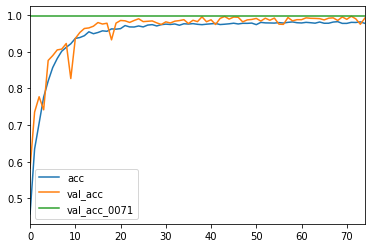

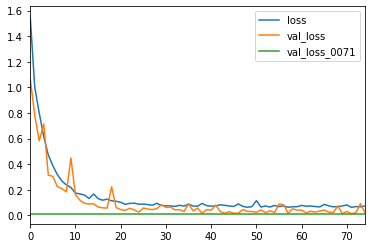

In [0]:
trainImageGeneration = ImageDataGenerator(
    rescale = 1./255,
    shear_range=0.2,
    zoom_range=0.05,
    width_shift_range=0.2,
    height_shift_range=0.02,
    rotation_range = 20,
    horizontal_flip=True
)

trainGenerator = trainImageGeneration.flow_from_directory(
    train_dir,
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    color_mode = 'grayscale'
)


modelTwo = Sequential([
  # Create two Convolutional layers, one with strides and padding. After these two, max pool to allow variance 
  Conv2D(32, (3,3), padding='same', input_shape = TARGET_SIZE + [1], activation='relu', strides = [1,1]),
  Conv2D(32, (3,3), activation='relu'),
  MaxPooling2D(pool_size=(2,2) ),

  # Create two convolutional layers of 64 each, no strides or padding as we want to learn the smaller details
  Conv2D(64, (5,5),activation='relu'),
  Conv2D(64, (3,3),activation='relu'),
  MaxPooling2D(pool_size=(2,2) ) ,

  # Flatten the input, create 128 Dense nodes on Relu and output to 16 Nodes with a softmax for our final outcome.
  Flatten(),
  Dense(128, activation='relu'),
  Dense(16, activation='softmax')
])
modelTwo.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])
plot_model(modelTwo, to_file='model.png', show_layer_names=True, show_shapes=True)


h2 = modelTwo.fit_generator(
    trainGenerator,
    steps_per_epoch = TOTAL_TRAIN_IMAGES // BATCH_SIZE, # 8800 // 32
    epochs = TOTAL_EPOCHS, # 75
    validation_data = validationGenerator,
    validation_steps = TOTAL_VALIDATION_IMAGES // BATCH_SIZE, # 3200 // 32
    callbacks = callbacks
)

save_history(h2, './')


Epoch 1/25
275/275 [==============================] - 30s 109ms/step - loss: 1.9167 - acc: 0.3181 - val_loss: 1.2355 - val_acc: 0.5306
Epoch 2/25
275/275 [==============================] - 29s 104ms/step - loss: 1.2959 - acc: 0.5166 - val_loss: 0.8734 - val_acc: 0.6653
Epoch 3/25
275/275 [==============================] - 29s 104ms/step - loss: 0.9995 - acc: 0.6290 - val_loss: 0.6363 - val_acc: 0.7784
Epoch 4/25
275/275 [==============================] - 28s 103ms/step - loss: 0.7629 - acc: 0.7178 - val_loss: 0.4879 - val_acc: 0.8069
Epoch 5/25
275/275 [==============================] - 29s 104ms/step - loss: 0.6046 - acc: 0.7683 - val_loss: 0.3589 - val_acc: 0.8534
Epoch 6/25
275/275 [==============================] - 29s 104ms/step - loss: 0.5060 - acc: 0.8020 - val_loss: 0.3617 - val_acc: 0.8422
Epoch 7/25
275/275 [==============================] - 29s 106ms/step - loss: 0.4349 - acc: 0.8358 - val_loss: 0.2724 - val_acc: 0.8838
Epoch 8/25
275/275 [==============================] - 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  if __name__ == '__main__':


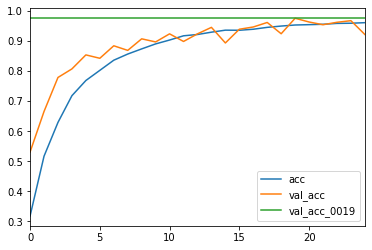

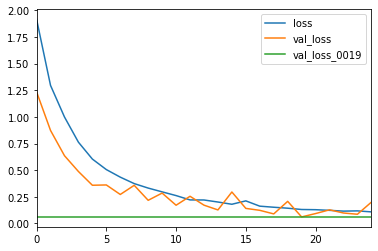

In [0]:
modelThree = Sequential()
modelThree.add(Conv2D(32, (3,3), padding='same', input_shape = TARGET_SIZE + [1], activation='relu', strides = [1,1]))
modelThree.add(Conv2D(32, (3,3), activation='relu'))
modelThree.add(MaxPooling2D(pool_size=(2,2) ) )

modelThree.add(Conv2D(64, (3,3),activation='relu', strides=(1,1), padding='same'))
modelThree.add(Conv2D(64, (3,3),activation='relu'))
modelThree.add(MaxPooling2D(pool_size=(2,2) ) )

modelThree.add(Conv2D(128, (3,3),activation='relu', strides=(2,2), padding='same'))
modelThree.add(Conv2D(128, (3,3),activation='relu'))
modelThree.add(MaxPooling2D(pool_size=(2,2) ) )

#modelThree.add(Conv2D(256, (3,3),activation='relu', strides=(2,2), padding='same'))
#modelThree.add(Conv2D(256, (3,3),activation='relu'))
#modelThree.add(MaxPooling2D(pool_size=(2,2) ) )

modelThree.add(Flatten())
modelThree.add(Dense(512))
modelThree.add(Activation('relu'))
modelThree.add(Dense(16))
modelThree.add(Activation('softmax'))

modelThree.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])



h3 = modelThree.fit_generator(
    trainGenerator,
    steps_per_epoch = TOTAL_TRAIN_IMAGES // BATCH_SIZE,
    epochs = TOTAL_EPOCHS,
    validation_data = validationGenerator,
    validation_steps = TOTAL_VALIDATION_IMAGES // BATCH_SIZE,
    callbacks = callbacks
)

save_history(h3, './')


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/25
275/275 [==============================] - 31s 112ms/step - loss: 1.7913 - acc: 0.3615 - val_loss: 1.1628 - val_acc: 0.5581
Epoch 2/25
275/275 [==============================] - 29s 105ms/step - loss: 1.2136 - acc: 0.5555 - val_loss: 0.7504 - val_acc: 0.7125
Epoch 3/25
275/275 [==============================] - 29s 105ms/step - loss: 0.8726 - acc: 0.6790 - val_loss: 0.5519 - val_acc: 0.7956
Epoch 4/25
275/275 [==============================] - 29s 105ms/step - loss: 0.6300 - acc: 0.7722 - val_loss: 0.3904 - val_acc: 0.8500
Epoch 5/25
275/275 [==============================] - 29s 104ms/step - loss: 0.5044 - acc: 0.8151 - val_loss: 0.3159 - val_acc: 0.8716
Epoch 6/25
275/275 [==============================] - 29s 104ms/step - loss: 0.4058 - acc: 0.8453 - val_loss: 0.3061 - val_acc: 0.8638
Epoch 7/25
275/275 [==============================] - 29s 105ms/step - los

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  if __name__ == '__main__':


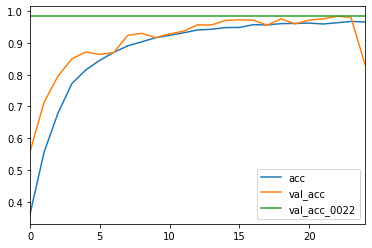

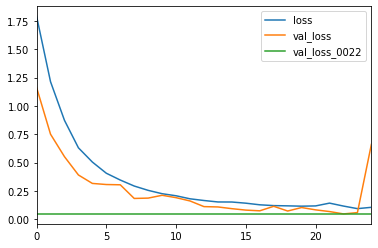

In [0]:
modelFour = Sequential()

modelFour.add(Conv2D(16, (3,3), padding='same', input_shape = TARGET_SIZE + [1], activation='relu', strides = [1,1])) # First Layer To
modelFour.add(Conv2D(32, (3,3), strides=(1,1), activation='relu'))
modelFour.add(MaxPooling2D(pool_size=(2,2) ) )

modelFour.add(Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu'))
modelFour.add(Conv2D(64, (3,3), strides=[1,1], activation='relu', padding='same'))
modelFour.add(MaxPooling2D(pool_size=(2,2) ) )

modelFour.add(Conv2D(128, (3,3),activation='relu', strides=(1,1), padding='same'))
modelFour.add(MaxPooling2D(pool_size=(2,2) ) )


modelFour.add(Flatten())
modelFour.add(Dense(512, activation='relu'))
modelFour.add(Dropout(.05))
modelFour.add(Dense(16, activation='softmax'))

modelFour.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])



h4 = modelFour.fit_generator(
    trainGenerator,
    steps_per_epoch = TOTAL_TRAIN_IMAGES // BATCH_SIZE,
    epochs = TOTAL_EPOCHS,
    validation_data = validationGenerator,
    validation_steps = TOTAL_VALIDATION_IMAGES // BATCH_SIZE,
    callbacks = callbacks
)

save_history(h4, './')

Found 8800 images belonging to 16 classes.
Epoch 1/1
275/275 [==============================] - 26s 96ms/step - loss: 1.7676 - acc: 0.3755 - val_loss: 1.2151 - val_acc: 0.5178


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


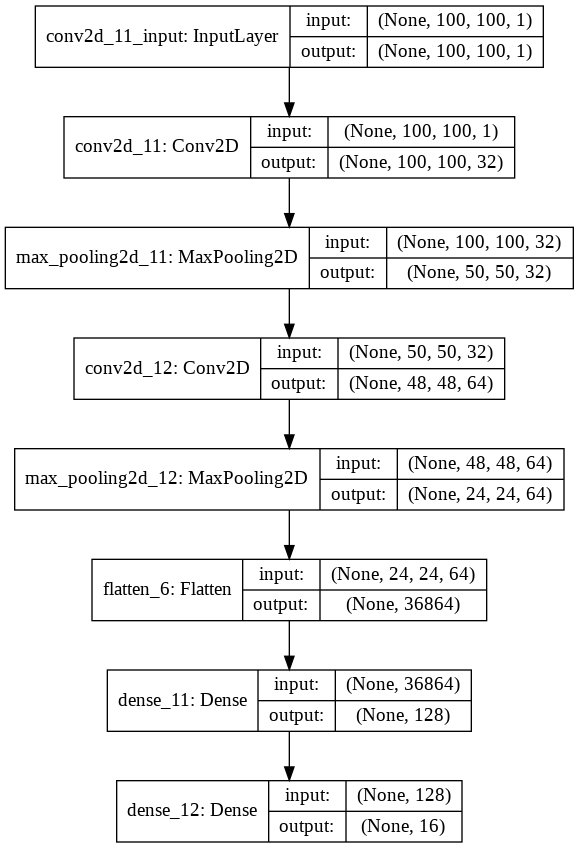

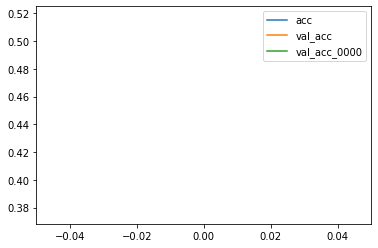

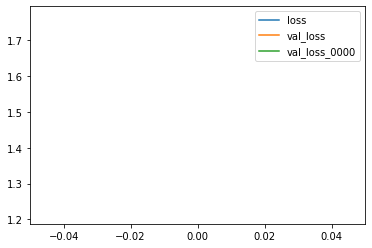

In [0]:
trainImageGenerationAug = ImageDataGenerator(
    rescale = 1./255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2
)

trainGeneratorAug = trainImageGenerationAug.flow_from_directory(
    train_dir,
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    color_mode = 'grayscale'
)

modelOneAug = Sequential()
modelOneAug.add(Conv2D(32, (3,3), padding='same', input_shape = TARGET_SIZE + [1], activation='relu', strides = [1,1])) # 32 Layer COnv2d Layer with padding and strides of 1,1
modelOneAug.add(MaxPooling2D(pool_size=(2,2) ) ) # Max Pooling output: 2x2

modelOneAug.add(Conv2D(64, (3,3),activation='relu')) # Conv2D layers of 64 with Relu activation
modelOneAug.add(MaxPooling2D(pool_size=(2,2) ) ) # Max Pooling output: 2x2

modelOneAug.add(Flatten()) # 
modelOneAug.add(Dense(128, activation='relu'))
modelOneAug.add(Dense(16, activation='softmax'))

modelOneAug.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])



h1 = modelOneAug.fit_generator(
    trainGeneratorAug,
    steps_per_epoch = TOTAL_TRAIN_IMAGES // BATCH_SIZE,
    epochs = 1,#TOTAL_EPOCHS,
    validation_data = validationGenerator,
    validation_steps = TOTAL_VALIDATION_IMAGES // BATCH_SIZE,
    callbacks = callbacks
)

save_history(h1, './')
plot_model(modelOneAug, to_file='model.png', show_layer_names=True, show_shapes=True)


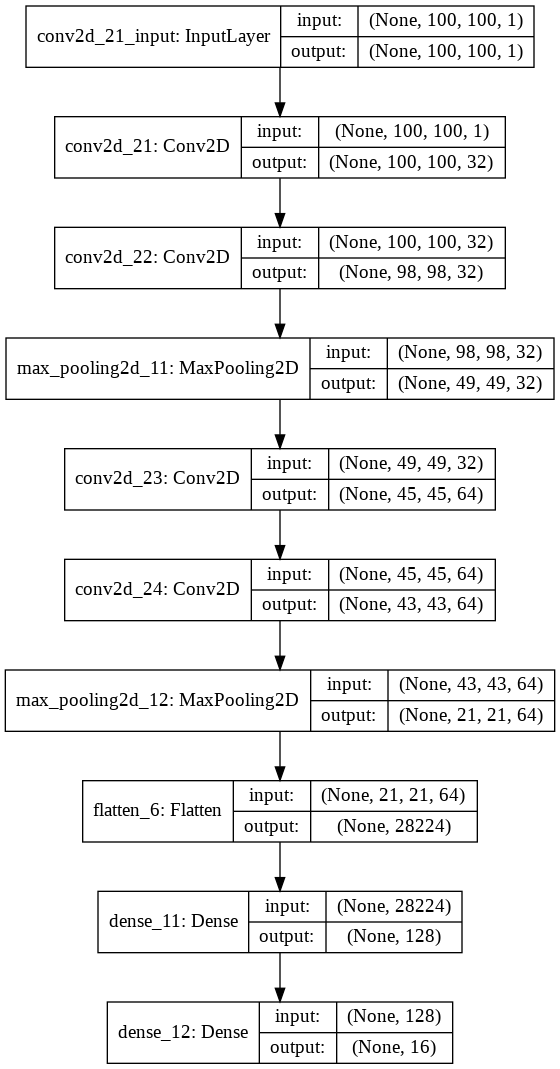

In [0]:
plot_model(modelTwo, to_file='modelTwo.png', show_shapes=True, show_layer_names=True)